# Simple water-table solution with recharge

This problem is an unconfined system with a uniform recharge rate, a horizontal bottom, and flow between constant-head boundaries in column 1 and 100. MODFLOW models cannot match the analytical solution exactly because they do not allow recharge to constant-head cells. Constant-head cells in column 1 and 100 were made very thin (0.1 m) in the direction of flow to minimize the effect of recharge applied to them. The analytical solution for this problem can be written as:

$h = \sqrt{b_{1}^{2} - \frac{x}{L} (b_{1}^{2} - b_{2}^{2}) + (\frac{R x}{K}(L-x))} + z_{bottom}$

where $R$ is the recharge rate, $K$ is the the hydraulic conductivity in the horizontal direction, $b_1$ is the specified saturated thickness at the left boundary, $b_2$ is the specified saturated thickness at the right boundary, $x$ is the distance from the left boundary $L$ is the length of the model domain, and $z_{bottom}$ is the elebation of the bottom of the aquifer.

The model consistes of a grid of 100 columns, 1 row, and 1 layer; a bottom altitude of 0 m; constant heads of 20 and 11m in column 1 and 100, respectively; a recharge rate of 0.001 m/d; and a horizontal hydraulic conductivity of 50 m/d.  The discretization is 0.1 m in the row direction for the constant-head cells (column 1 and 100) and 50 m for all other cells.

In [1]:
import sys
from pathlib import Path
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

proj_root = Path.cwd().parent.parent

# run installed version of flopy or add local path
try:
    import flopy
except:
    sys.path.append(proj_root)
    import flopy

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

3.11.0 | packaged by conda-forge | (main, Jan 15 2023, 05:44:48) [Clang 14.0.6 ]
numpy version: 1.24.2
matplotlib version: 3.6.3
flopy version: 3.3.7


In [2]:
# Set name of MODFLOW exe
#  assumes executable is in users path statement
exe_name = "mfnwt"
mfexe = exe_name

Create a temporary workspace.

In [3]:
temp_dir = TemporaryDirectory()
workspace = Path(temp_dir.name)
workspace.mkdir(exist_ok=True)
modelname = "watertable"

Define a function to calculate the analytical solution at specified points in an aquifer.

In [4]:
def analytical_water_table_solution(h1, h2, z, R, K, L, x):
    h = np.zeros((x.shape[0]), float)
    # dx = x[1] - x[0]
    # x -= dx
    b1 = h1 - z
    b2 = h2 - z
    h = (
        np.sqrt(
            b1**2 - (x / L) * (b1**2 - b2**2) + (R * x / K) * (L - x)
        )
        + z
    )
    return h

Define model data required to create input files and calculate the analytical solution.

In [5]:
# model dimensions
nlay, nrow, ncol = 1, 1, 100

# cell spacing
delr = 50.0
delc = 1.0

# domain length
L = 5000.0

# boundary heads
h1 = 20.0
h2 = 11.0

# ibound
ibound = np.ones((nlay, nrow, ncol), dtype=int)

# starting heads
strt = np.zeros((nlay, nrow, ncol), dtype=float)
strt[0, 0, 0] = h1
strt[0, 0, -1] = h2

# top of the aquifer
top = 25.0

# bottom of the aquifer
botm = 0.0

# hydraulic conductivity
hk = 50.0

# location of cell centroids
x = np.arange(0.0, L, delr) + (delr / 2.0)

# location of cell edges
xa = np.arange(0, L + delr, delr)

# recharge rate
rchrate = 0.001

# calculate the head at the cell centroids using the analytical solution function
hac = analytical_water_table_solution(h1, h2, botm, rchrate, hk, L, x)

# calculate the head at the cell edges using the analytical solution function
ha = analytical_water_table_solution(h1, h2, botm, rchrate, hk, L, xa)

# ghbs
# ghb conductance
b1, b2 = 0.5 * (h1 + hac[0]), 0.5 * (h2 + hac[-1])
c1, c2 = hk * b1 * delc / (0.5 * delr), hk * b2 * delc / (0.5 * delr)
# dtype
ghb_dtype = flopy.modflow.ModflowGhb.get_default_dtype()
print(ghb_dtype)
# build ghb recarray
stress_period_data = np.zeros((2), dtype=ghb_dtype)
stress_period_data = stress_period_data.view(np.recarray)
print("stress_period_data: ", stress_period_data)
print("type is: ", type(stress_period_data))
# fill ghb recarray
stress_period_data[0] = (0, 0, 0, h1, c1)
stress_period_data[1] = (0, 0, ncol - 1, h2, c2)

[('k', '<i8'), ('i', '<i8'), ('j', '<i8'), ('bhead', '<f4'), ('cond', '<f4')]
stress_period_data:  [(0, 0, 0, 0., 0.) (0, 0, 0, 0., 0.)]
type is:  <class 'numpy.recarray'>


Create and run the MODFLOW-NWT model.

In [6]:
mf = flopy.modflow.Modflow(
    modelname=modelname, exe_name=mfexe, model_ws=workspace, version="mfnwt"
)
dis = flopy.modflow.ModflowDis(
    mf,
    nlay,
    nrow,
    ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    perlen=1,
    nstp=1,
    steady=True,
)
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
lpf = flopy.modflow.ModflowUpw(mf, hk=hk, laytyp=1)
ghb = flopy.modflow.ModflowGhb(mf, stress_period_data=stress_period_data)
rch = flopy.modflow.ModflowRch(mf, rech=rchrate, nrchop=1)
oc = flopy.modflow.ModflowOc(mf)
nwt = flopy.modflow.ModflowNwt(mf, linmeth=2, iprnwt=1, options="COMPLEX")
mf.write_input()

# remove existing heads results, if necessary
try:
    (workspace / f"{modelname}.hds").unlink(missing_ok=True)
except:
    pass
# run existing model
success, buff = mf.run_model(silent=True, report=True)
assert success, "Failed to run"
for line in buff:
    print(line)


                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.2.0 03/01/2020                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: watertable.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/05/01 21:55:04

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/05/01 21:55:04
 Elapsed run time:  0.025 Seconds

  Normal termination of simulation


Read the simulation's results.

In [7]:
# Create the headfile object
headfile = workspace / f"{modelname}.hds"
headobj = flopy.utils.HeadFile(headfile, precision="single")
times = headobj.get_times()
head = headobj.get_data(totim=times[-1])

Plot the MODFLOW-NWT results and compare to the analytical solution.

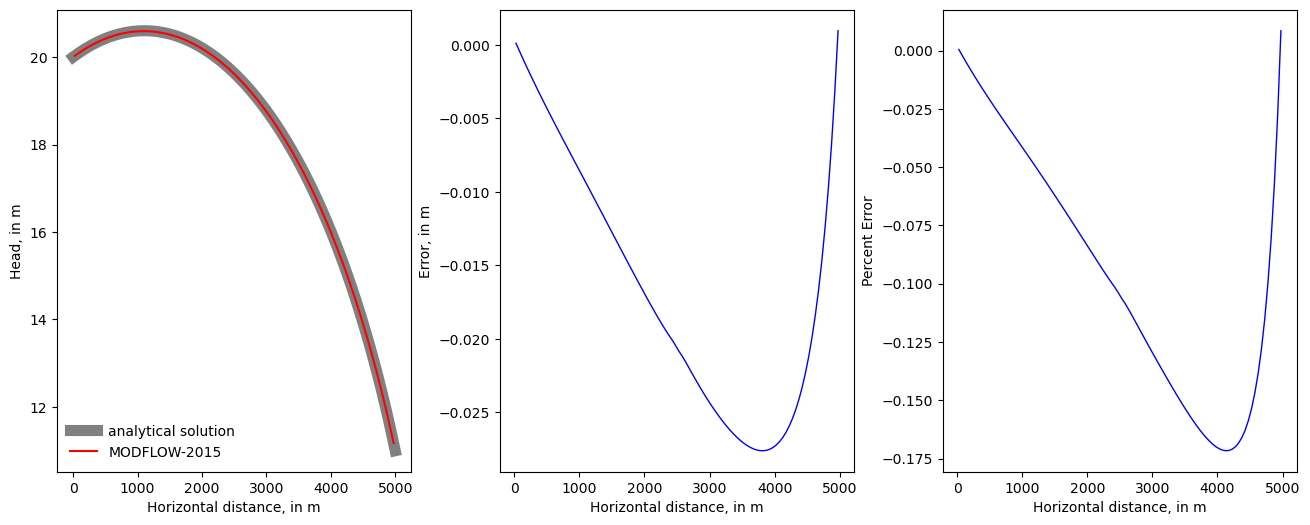

In [8]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.25
)

ax = fig.add_subplot(1, 3, 1)
ax.plot(xa, ha, linewidth=8, color="0.5", label="analytical solution")
ax.plot(x, head[0, 0, :], color="red", label="MODFLOW-2015")
leg = ax.legend(loc="lower left")
leg.draw_frame(False)
ax.set_xlabel("Horizontal distance, in m")
ax.set_ylabel("Head, in m")

ax = fig.add_subplot(1, 3, 2)
ax.plot(x, head[0, 0, :] - hac, linewidth=1, color="blue")
ax.set_xlabel("Horizontal distance, in m")
ax.set_ylabel("Error, in m")

ax = fig.add_subplot(1, 3, 3)
ax.plot(x, 100.0 * (head[0, 0, :] - hac) / hac, linewidth=1, color="blue")
ax.set_xlabel("Horizontal distance, in m")
ax.set_ylabel("Percent Error");

In [9]:
try:
    # ignore PermissionError on Windows
    temp_dir.cleanup()
except:
    pass